# Assignment: Celeberity Classification using PCA Dimensionality Reduction

### Name:

### Due Date: 


In [1]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

##1. Data preparation


### 1.1. Load data


In [8]:
from numpy import load
import numpy as np
from PIL import Image

data = load('celebrity_data.npy', allow_pickle=True)

### 1.2. Pre-Processing The Data

Right now, our image data is stored in 2 tuples: (images, labels). We'd like to have our data seperated - one array containing images in the shape ```(#imgs, height, width)``` and seperate array for their labels. Below is the preprocessing code. 

Since we're doing classification, we'll also need to encode each label into an numeric form the model can interpret

In [9]:
# Initialize array
faces = []
labels = []

# Unzip images & labels
faces, labels = zip(*data)

faces = np.stack(faces)
labels = np.asarray(labels)

# Remove unecessary information on labels
for i in range(labels.shape[0]):
  labels[i] = labels[i].split('-cropped')[0]

In [12]:

# Get all the unique labels
unique_labels = np.unique(labels)
label_encoder = {}
label_decoder = {}
for i, label in enumerate(unique_labels):
  label_encoder[label] = i
  label_decoder[i] = label

int_labels = np.zeros(labels.shape)

# Make an array to hold encoded labels
for i in range(labels.shape[0]):
  int_labels[i] =  int(label_encoder[labels[i]])

#  Assign seperated data
target_names, faces, int_labels = np.unique(labels), np.asarray(faces), np.asarray(int_labels)
num_samples, h, w = faces.shape

In order to perform SVD on our image data, we need to represent ALL of our data into a single 2D matrix. 

* We apply un"ravel" to each image to transfrom each 2D image```(200, 200)```  into a single vector ```(, 40000)``` 
* We combine these flattened vectors into the ```(1683, 40000)``` matrix representing all our data


In [13]:
flattened_faces = []
for i in range(faces.shape[0]):
  flattened_faces.append(np.ravel(faces[i]))
  
flattened_faces = np.asarray(flattened_faces)
print(flattened_faces.shape)

(1668, 6000)


In [14]:
# Split data into trianing / testing
training_images, testing_images, training_labels, testing_labels = train_test_split(flattened_faces, int_labels, test_size=0.2, random_state=42)

## 2. Normalization

In order to apply PCA, we need to make sure our data is normalized. 

1. Compute the ```Average Face``` for each pixel from all celebrity images. Since each image is a column vector of our array, the mean of the *row* will be the average for that particular pixel.
2. Subtract out the resulting ```Average Face``` from all our training images.

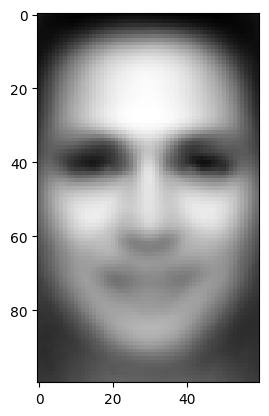

In [15]:
# Compute average face
avg_face = np.mean(training_images, axis=0)
plt.imshow(avg_face.reshape(h, w), cmap="gray")

In [16]:
## Helper functions for displaying faces
def sample_results(images): 
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(h, w), cmap='gray')
  plt.show()

def sample_results_reshaped(images): 
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()

~~~~ Original Faces ~~~~


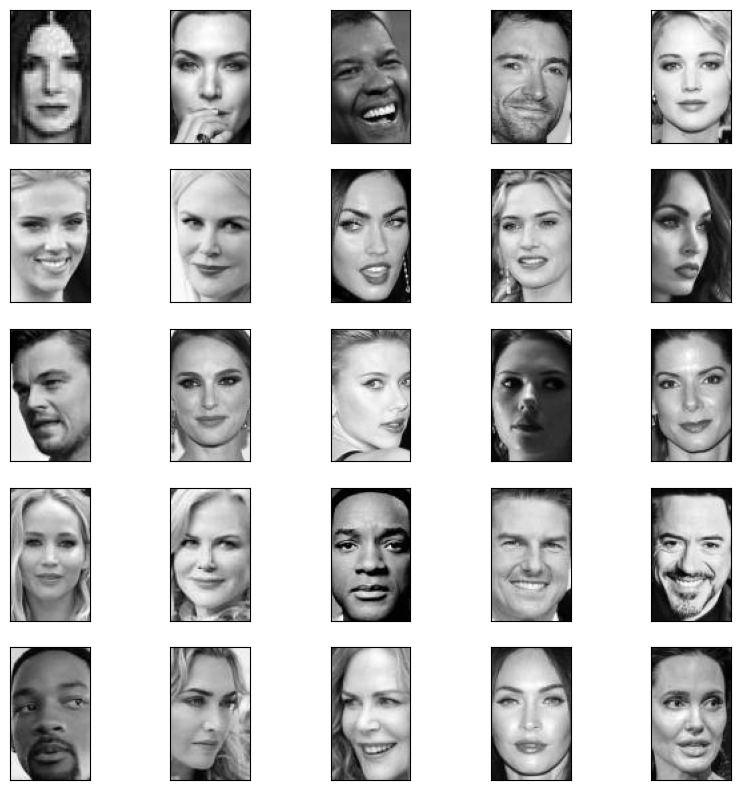

~~~~ Normalized Faces ~~~~


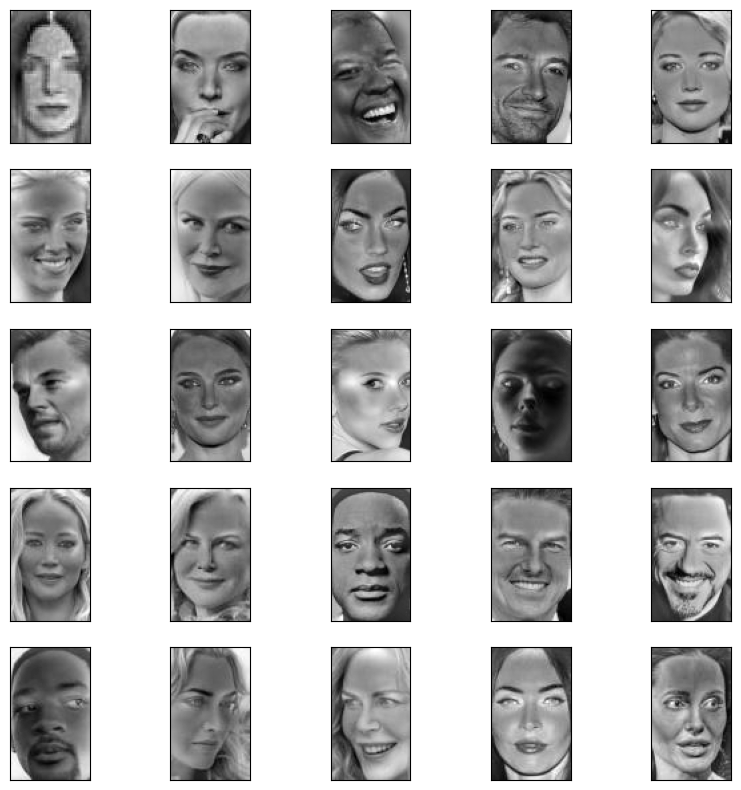

In [17]:
# Compute normalized faces for each training image
norm_training = training_images - avg_face
print("~~~~ Original Faces ~~~~")
sample_results(training_images)
print('~~~~ Normalized Faces ~~~~')
sample_results(norm_training)

## 3. Apply PCA 

Now that all our data is normalized, we can go about computing the PCA dimension reduction of our images. 

1. First we compute the Singular Value Decomposition (SVD) of all facial images in our dataset. SVD breaks down the data into the form ```{U, S, Vt}```, where the product of each column of U, value of S & row of Vt encodes a defining characteristic of the total data. We call U & Vt, the left and right singular vectors of A and S the diagonal matrix of singular values.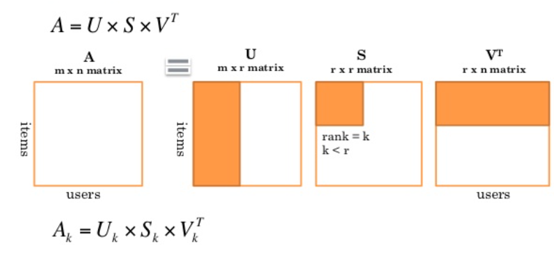 <br>The first k columns Uk, singular values Sk, and rows Vtk represent the k most important features of the image data. For example, the first few singular values and corresponding singular vectors may encode basic features of the faces, such as the overall brightness, contrast, and sharpness of the images. The middle singular values and corresponding singular vectors may encode more subtle features of the faces, like the shape of the eyes, nose, and mouth, and the overall shape and proportion of the face. 

2. Take the product of the first k singular vectors & singular values of our SVD encoded data. The resulting matrix ```Ak``` represents a compressed version of our image data, which only includes the ```k most important features``` of our data. That means we can get fairly good results working with a fraction of the stored data. This process is known as ```Principal Component Analysis``` or PCA.

In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from numpy.linalg import svd


# Define function for computing SVD
def compute_svd(k, norm_training):
  U, S, Vt = svd(np.transpose(norm_training), full_matrices=False)
  return U, S, Vt

# Function for computing k-rank PCA 
def kPCA_eigenface(k, U, S, Vt, avg_face):
  return np.matmul(U[:, :k], np.matmul(np.diag(S[:k]), Vt[:k, :])) + np.transpose(avg_face)[:, np.newaxis]

## 4. Evaluation

After we've computed the k-rank PCA reduction of the image data, we'd like to see how well it performs. One metric we can examine is how well a classification model performs when trained on different values of k. 

Here we train a CNN model to perform classification on 
k = ```{1, 2, 4, ..., 1024} ``` and plot the accuracy for each.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from numpy.linalg import svd

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from tensorflow.image import psnr
from tensorflow.math import reduce_sum

# Define function for computing SVD
def compute_svd(k, norm_training):
  U, S, Vt = svd(np.transpose(norm_training), full_matrices=False)
  return U, S, Vt

# Function for computing k representations of each face
def kPCA_eigenface(k, U, S, Vt, avg_face):
  return np.matmul(U[:, :k], np.matmul(np.diag(S[:k]), Vt[:k, :])) + np.transpose(avg_face)[:, np.newaxis]

# Function to automate process of testing k
def run_k_model(k, training_images, training_labels, testing_images, testing_labels, avg_face):

  print(training_images.shape)
  print(training_labels.shape)
  print(testing_images.shape)
  print(testing_labels.shape)

  # Compute PCA for rank-k on cifar images
  U, S, Vt = compute_svd(k, training_images - avg_face)
  ktraining_images = (kPCA_eigenface(k, U, S, Vt, avg_face))
  ktraining_images = np.asarray([ktraining_images[:, i].reshape(h, w) for i in range(len(ktraining_images[0]))])
  print(ktraining_images.shape)

  # Compute Accuracy Metrics
  MSE, SSI, PSNR = 0, 0, 0
  num_samples = len(ktraining_images)
  conv_training_images = training_images.reshape(num_samples, h, w)
  
  PSNR = psnr(conv_training_images.reshape(num_samples, h, w, 1), ktraining_images.reshape(num_samples, h, w, 1), max_val=1)

  for i in range(num_samples):
    # print(f"Training: {conv_training_images[i].shape}")
    # print(f"ktraining_images: {ktraining_images[i].shape}")
    MSE += mean_squared_error(conv_training_images[i], ktraining_images[i])
    SSI += ssim(conv_training_images[i], ktraining_images[i], data_range=ktraining_images[i].max() - ktraining_images[i].min())
  
  PSNR = reduce_sum(PSNR) / num_samples
  MSE /= num_samples
  SSI /= num_samples

  validation_split = 0.8

  # Split between validation and training data
  kvalidation_images = ktraining_images[int(validation_split * num_samples):] 
  ktraining_images = ktraining_images[0:int(validation_split * num_samples)]
  kvalidation_labels = training_labels[int(validation_split * num_samples):] 
  ktraining_labels = training_labels[0: int(validation_split * num_samples)]

  # sample_results_reshaped(ktraining_images)

  # Defining Convolutional Model
  model = models.Sequential()
  model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(h, w, 1)))
  model.add(layers.Dropout(0.25))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(17, activation='softmax'))

  # Compile and compute model
  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  history = model.fit(ktraining_images, ktraining_labels, epochs=25, validation_data=(kvalidation_images, kvalidation_labels))
  
  # Evaluate & display results
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title(f"Epoch vs Accuracy for rank-{k}")
  plt.ylim(0, 1)
  plt.savefig(f'{k}rank-acc.png')
  plt.show()

  # print(testing_images.shape)
  # print(testing_labels.shape)

  testing_images = np.asarray([testing_images[i].reshape(h, w) for i in range(len(testing_labels))])

  test_loss, test_acc = model.evaluate(testing_images, testing_labels, verbose=2)
  print(f"Testing Loss for rank {k}: {test_loss}")
  print(f"Testing Accurracy for rank {k}: {test_acc}")
  print(f"Img Quality Metrics ~ MSE: {MSE} | SSI: {SSI} | PSNR: {PSNR}")

  return test_loss, test_acc, [MSE, SSI, PSNR]


(1334, 6000)
(1334,)
(334, 6000)
(334,)
(1334, 100, 60)


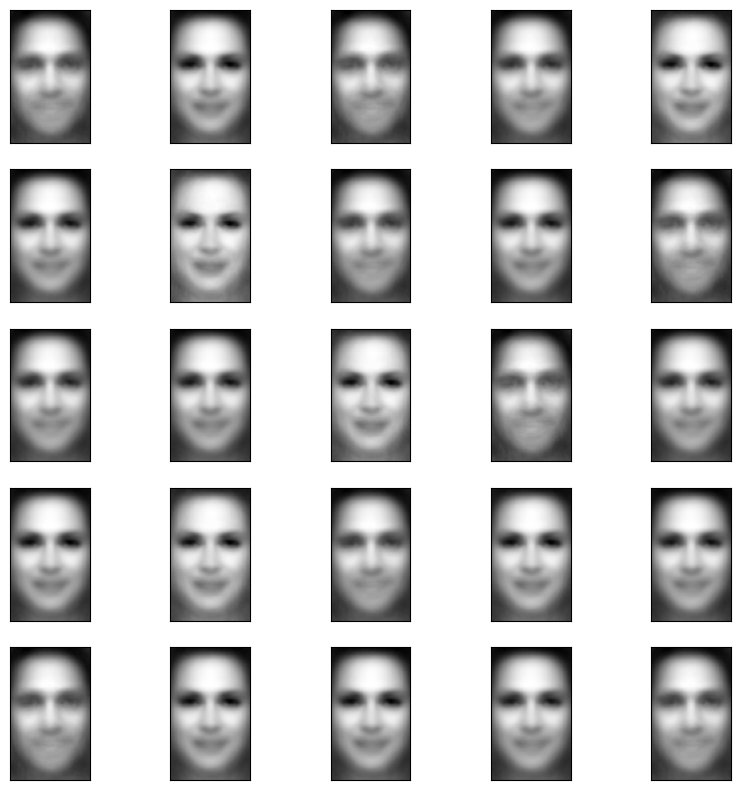

Epoch 1/25
34/34 [==============================] - 2s 15ms/step - loss: 32.1247 - accuracy: 0.0769 - val_loss: 2.8335 - val_accuracy: 0.0562
Epoch 2/25
34/34 [==============================] - 0s 8ms/step - loss: 2.8241 - accuracy: 0.0769 - val_loss: 2.8311 - val_accuracy: 0.0412
Epoch 3/25
34/34 [==============================] - 0s 8ms/step - loss: 2.7889 - accuracy: 0.1059 - val_loss: 2.7542 - val_accuracy: 0.1723
Epoch 4/25
34/34 [==============================] - 0s 9ms/step - loss: 2.8119 - accuracy: 0.1246 - val_loss: 2.8271 - val_accuracy: 0.1423
Epoch 5/25
34/34 [==============================] - 0s 8ms/step - loss: 2.8019 - accuracy: 0.1265 - val_loss: 2.7782 - val_accuracy: 0.0637
Epoch 6/25
34/34 [==============================] - 0s 9ms/step - loss: 2.7408 - accuracy: 0.1331 - val_loss: 2.6715 - val_accuracy: 0.1760
Epoch 7/25
34/34 [==============================] - 0s 8ms/step - loss: 2.6832 - accuracy: 0.1490 - val_loss: 2.6390 - val_accuracy: 0.1723
Epoch 8/25
34/34 [

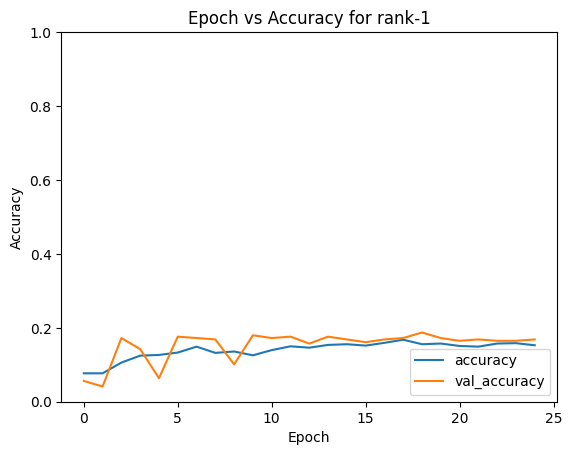

11/11 - 0s - loss: 3.5133 - accuracy: 0.0928 - 235ms/epoch - 21ms/step
Testing Loss for rank 1: 3.5133326053619385
Testing Accurracy for rank 1: 0.0928143709897995


In [ ]:
results = []
total_iterations = 11
for i in range(1):
  results.append(run_k_model(2**i, training_images, training_labels, testing_images, testing_labels, avg_face))

### 4.1 Cleaning Results



In [ ]:
# Unzip results
zipped_results = list(zip(*results))
print(zipped_results)
test_loss = zipped_results[0]
test_acc = zipped_results[1]
img_quality_metrics = zipped_results[2]
ranks = [i for i in range(total_iterations)]

[(3.5133326053619385,), (0.0928143709897995,), ([<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([2675.54118924, 2644.35021058, 2674.40173001, 2653.78041257,
       2632.12769821, 2635.41708562, 2541.91389759, 2468.09476611,
       2322.67693766, 2141.93417661, 2015.98165104, 1850.68194103,
       1732.43558668, 1642.52240534, 1541.05141688, 1486.69137912,
       1423.99872195, 1364.70417847, 1332.38421385, 1293.60868181,
       1259.18536174, 1234.09998659, 1204.6746444 , 1201.10014119,
       1183.96855416, 1169.8253621 , 1171.25423376, 1172.77392269,
       1204.51397219, 1285.49515375, 1376.36068663, 1531.82894995,
       1694.01432607, 1777.07036566, 1788.49680613, 1749.13048026,
       1722.92024557, 1772.58486631, 1862.78079717, 1973.0868204 ,
       2022.14836478, 1980.61404263, 1963.19575948, 1853.60619863,
       1734.04102102, 1590.21410505, 1454.17989029, 1367.23338407,
       1283.88272543, 1211.0228706 , 1175.30132169, 1134.43834439,
       1110.33790783, 1108.74432

IndexError: ignored

### 4.2 Plotting Model Accuracy

(4.060532569885254,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


ValueError: ignored

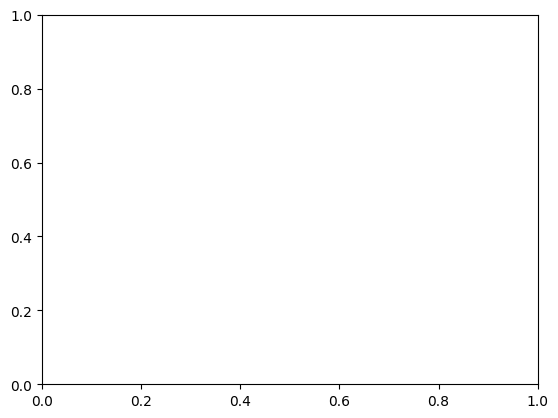

In [ ]:
print(test_loss)
print(ranks)
# Plot test loss
plt.plot(ranks, test_loss, label='Test Loss')
plt.xlabel('Rank')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Loss")
plt.ylim(0, 2.5)
plt.savefig('test_loss.png')
plt.show()

plt.plot(ranks, test_acc, label='Test Acc')
plt.xlabel('log2(Rank)')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Accuracy")
plt.ylim(0, 1)
plt.savefig('test_acc.png')
plt.show()

### 4.3 Plotting Evaluation Metrics

In [ ]:
# Get evaluation metrics
MSE, SSI, PSNR = zip(*img_quality_metrics)

In [ ]:
# Plotting MSE
plt.plot(ranks, test_acc, label='Test Acc')
plt.xlabel('log2(Rank)')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Accuracy")
plt.ylim(0, 1)
plt.savefig('test_acc.png')
plt.show()

# Plotting SSIM
plt.plot(ranks, test_acc, label='Test Acc')
plt.xlabel('log2(Rank)')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Accuracy")
plt.ylim(0, 1)
plt.savefig('test_acc.png')
plt.show()

# Plotting PSNR
plt.plot(ranks, test_acc, label='Test Acc')
plt.xlabel('log2(Rank)')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Accuracy")
plt.ylim(0, 1)
plt.savefig('test_acc.png')
plt.show()